In [5]:
%matplotlib inline
from matplotlib.pyplot import *
from numpy import *
# Don't import too much globally like we did pyplot and numpy
# pandas will break datetime if they are imported globally.
import datetime
import pytz
import pysolar
import pandas              # pandas for data science

# This lets you make the default figure size larger (or smaller)
from IPython.core.pylabtools import figsize
#figsize(8,8)

## Solar Heat Gain in a Condo
We can start by using the results from the previous Solar Values notebook to get sunlight falling on our windows over the course of a day.

In [6]:
def solarR(d,elev = 0,dir = 180,latitude_deg = 44.2,longitude_deg = -76.5):
    # solar radiation falling on a surface at compass angle dir
    # and elevation angle elev under a clear sky at datetime d
    # in Kingston, Ontario
    rpd = pi / 180. # radians per degree
    azi = pysolar.solar.get_azimuth(latitude_deg, longitude_deg, d)   # azimuth angle
    alt = pysolar.solar.get_altitude(latitude_deg, longitude_deg, d)  # altitude angle
    # Unit vector pointing at the sun. RHR coords with x west, y south
    uVecSun = array([   sin((-180 + azi) * rpd) * cos(alt * rpd),
                        cos((-180 + azi) * rpd) * cos(alt * rpd),
                        sin(alt * rpd)])
    # Unit vector normal to the panel. RHR coords with x west, y south
    uVecPanel = array([ sin((-180 + dir) * rpd) * sin(elev * rpd),
                        cos((-180 + dir) * rpd) * sin(elev * rpd),
                        cos(elev * rpd)])
    # Reduce by the dot product between the sun vector and the panel vector
    rad = pysolar.solar.radiation.get_radiation_direct(d, alt) * dot(uVecSun,uVecPanel)
    if rad < 0: rad = 0   # sun is behind panel
    return rad

## The windows are vertical and face south and it is January 26th.

Text(0,0.5,'Radiation Intensity [W/m**2]')

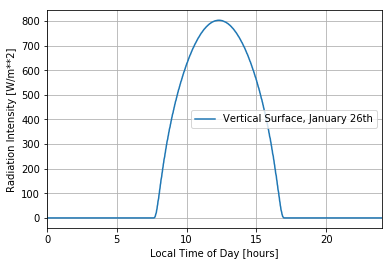

In [7]:
el = 90            # elevation of the panel, 0 degrees for horizontal
di = 180           # compass direction for the panel, 180 degrees for south

timezone = pytz.timezone("America/Toronto")  # includes Kingston
t = linspace(0,23.999,1000)    
i = t.copy()              
for j in range(0,len(t)): # for all the different hours in the day 
    th = int(t[j])        # convert to hours and minutes
    tm = int((t[j]-th)*60)
    # pysolar 0.8 requires timezone aware datetimes
    d = timezone.localize(datetime.datetime(2019, 1, 26, th,tm))  
    i[j] = solarR(d,el,di)

plot(t,i,label = 'Vertical Surface, January 26th')
grid()
legend()
xlim(0,24)
xlabel('Local Time of Day [hours]')
ylabel('Radiation Intensity [W/m**2]')

## Integrate to get total energy (insolation) over the course of the day
We can get a total insolation energy for the day by taking the mean of the intensity and multiplying by the number of hours we averaged over. The factor of 1000 converts from Watts to kiloWatts to MegaWatts and the factor of 3600 from hours to seconds. 

This is equivalent to doing a numerical integration of intensity over time, $\int i\,dt$.

Note that both kilowatt hours and MegaJoules are convenient magnitudes as units for household heating energy. 1 kWh = 3.6 MJ. Stick with Joules in calculations for consistency, but consider converting to these units when printing results.

In [8]:
daily = mean(i) * 24 / 1000
print('For a panel facing compass direction {0:4d} deg and elevated {1:2d} deg above horizontal:'.format(di,el))
print('  Mean Daily Insolation {0:5.2f} kWh/m**2 under Clear Skies ({1:5.2f} MJ/m**2)'.format(daily,daily*3600/1000))

For a panel facing compass direction  180 deg and elevated 90 deg above horizontal:
  Mean Daily Insolation  5.06 kWh/m**2 under Clear Skies (18.21 MJ/m**2)


## Kingston is a pretty sunny place
Still, we need data like https://www.nrcan.gc.ca/18366 to bring us back to the real world with geographic data for actual average insolation values. The Mean daily global insolation (kWh/m2 or full sun hours (h)) for January is 3.29 kWh daily for 1 square metre on a vertical surface like a window. On average only a fraction 3.29/5.06 = 0.65 of the solar radiation is getting through the clouds and weather.

Of that reduced intensity, only a fraction of it is transmitted through the windows to warm the interior, maybe 60%, depending on the window design.

Assuming we have 10 square metres of south facing windows, we can calculate the solar gain, $q_s$. 

At this stage we can choose the simple average day from the NRCan data, or we could go to historical data for actual insolation intensity as a function of time. Try different values of `clouds` and see what happens.

Text(0,0.5,'Solar Heat Gain [W]')

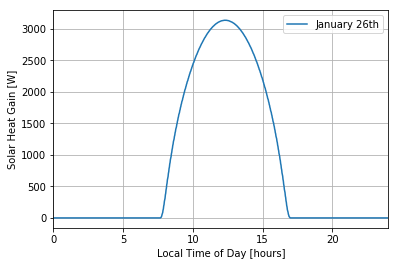

In [9]:
clouds = 0.65         # a value between 0 and 1 for the amount of light getting through the clouds 
trans  = 0.60         # a value between 0 and 1 for the amount of light getting through the window
Aw     = 10.0         # the surface area of the windows [m**2]
qs = Aw * i * trans * clouds

plot(t,qs,label = 'January 26th')
grid()
legend()
xlim(0,24)
xlabel('Local Time of Day [hours]')
ylabel('Solar Heat Gain [W]')

Assuming the heat is off, except for 500 W of nominal heat generation from people and appliances, etc., we can start out with the temperature indoors equal to 20C at midnight. The averaged thermal mass of the whole condo, air, furniture, appliances, construction materials means we are using a highly simplified model!

In [10]:
xAxis = zeros(len(t))
qi = zeros(len(t))
qa = ones(len(t))*500
Ti = ones(len(t))*20
To = ones(len(t))*-9
mCp = 30000000     # [J/C] thermal mass of the condo
lossFactor = 72    # [W/C] lost through the walls, windows and infiltration = 3.3 kW at 45C delta T

We don't know how the temperature is changing yet, but we can calculate rates of change and follow it through time steps of dt. That will also let us track the heat losses. The intial rate of change of temperature with time $dT_i/dt$ shouldn't disagree too much with what we actually observe.

In [11]:
dTdt = zeros(len(t))
qo = zeros(len(t))
qo[0] = (Ti[0]-To[0])*lossFactor
dTdt[0] = (qi[0]+qa[0]+qs[0]-qo[0])/mCp
dt = (t[1]-t[0])*3600   # delta t in seconds
print('The temperature will initially change by {0:6.3f} degrees C per hour.'.format(dTdt[0]*3600))

The temperature will initially change by -0.191 degrees C per hour.


## No Heaters
Now march along through time for all of the times in the day after the initial `t[0]`, starting with conditions at time `t[1]`. Euler's method uses the simplest possible first order estimate for the temperature at the new time. `qi[j]` is always equal to zero because the heaters aren't turned on. Unless there is a lot of sunshine, it will be colder at the end of the day than it was at the start.

Total input from heating system =         0 Joules or  0.00 kWh
Total input from passive solar  =  71104056 Joules or 19.75 kWh


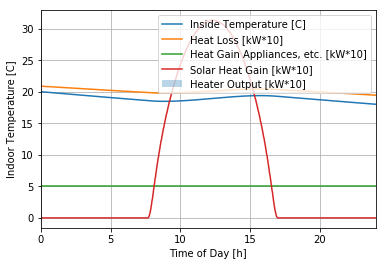

In [12]:
heatIn = 0                                      # total energy in from heaters
heatInSolar = 0                                 # total energy in from solar

for j in range(1,len(t)):                       # Iterate through the full day
    Ti[j] = Ti[j-1] + dTdt[j-1] * dt            # Euler estimate from previous dT/dt
    qo[j] = (Ti[j] - To[j]) * lossFactor        # current loss rate
    qi[j] = 0                                   # heat off
    # Calculate current dT/dt for next iteration, based on heat balance
    dTdt[j] = (qi[j] + qa[j] + qs[j] - qo[j]) / mCp    
    heatIn += qi[j] * dt                        # W*s => J accumulated heat addition
    heatInSolar += qs[j] * dt                   # W*s => J

# draw the graph
def drawHeatingHistory():
    plot(t,Ti,label='Inside Temperature [C]')
    plot(t,qo/100,label='Heat Loss [kW*10]')
    plot(t,qa/100,label='Heat Gain Appliances, etc. [kW*10]')
    plot(t,qs/100,label='Solar Heat Gain [kW*10]')
    fill_between(t,xAxis,qi/100,label='Heater Output [kW*10]',alpha = 0.3)
    xlim(0,24)
    grid()
    xlabel('Time of Day [h]')
    ylabel('Indoor Temperature [C]')
    legend()
    print('Total input from heating system = {0:9.0f} Joules or {1:5.2f} kWh'.format(heatIn,heatIn/3600000))
    print('Total input from passive solar  = {0:9.0f} Joules or {1:5.2f} kWh'.format(heatInSolar,heatInSolar/3600000))
    
drawHeatingHistory()

## Heating On with SetPoint Control
Now try it with the heaters turned on between 6:30 and 22:00. This version simply turns the heaters full on if the temperature is below the Setpoint temperature. Controlling heat addition this way will result in rapid on/off cycling for for the heaters, so a practical thermostat will have set/reset control or something even more complex to reduce the cycling. If you see a section that fades towards the top for Heater Output, that's a region of rapid on/off cycling.

Total input from heating system =  86188841 Joules or 23.94 kWh
Total input from passive solar  =  71104056 Joules or 19.75 kWh


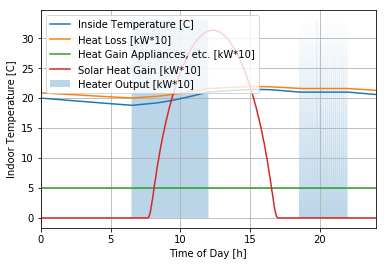

In [13]:
qMax = 3300         # Maximum Heater Output [W]
setPoint = 21       # set point [C] -- turn on if colder, turn off if warmer
heatIn = 0          # total energy in from heaters
heatInSolar = 0     # total energy in from solar
wake = 6.5          # hour to start heating, e.g. 6.5 = 06:30
sleep = 22.0        # hour to stop heating, e.g. 22.0 = 22:00 = 10 PM

for j in range(1,len(t)):                       # Iterate through the full day
    Ti[j] = Ti[j-1] + dTdt[j-1] * dt            # Euler estimate from previous dT/dt
    qo[j] = (Ti[j] - To[j]) * lossFactor        # current loss rate
    # if the thermostat is awake and the temperature is below the set point
    if(t[j] > wake and t[j] < sleep and Ti[j] < setPoint):
        qi[j] = qMax                            # heat full on
    else:
        qi[j] = 0                               # heat off
    # Calculate current dT/dt for next iteration, based on heat balance
    dTdt[j] = (qi[j] + qa[j] + qs[j] - qo[j]) / mCp    
    heatIn += qi[j] * dt                        # W*s => J accumulated heat addition
    heatInSolar += qs[j] * dt                   # W*s => J
    
drawHeatingHistory()

## Heat On with Set / Reset Control
We can do the same calculation, but waiting until the temperature rises a noticeable amount before turning the heat back off. We can remember the current state of the heaters with `heatOn`.

Total input from heating system =  86474235 Joules or 24.02 kWh
Total input from passive solar  =  71104056 Joules or 19.75 kWh


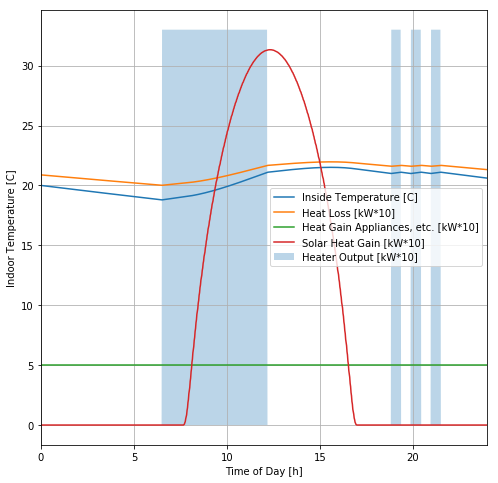

In [67]:
setPoint = 21.0              # Turn on if below this temperature [C]
resetPoint = 21.1            # Turn off if above this temperature [C]
heatOn = 0                   # 1 for heat full on, 0 for off
heatIn = 0
heatInSolar = 0

for j in range(1,len(t)):                       # Iterate through the full day
    Ti[j] = Ti[j-1] + dTdt[j-1] * dt            # Euler estimate from previous dT/dt
    qo[j] = (Ti[j] - To[j]) * lossFactor        # current loss rate
    if(t[j] > 6.5 and t[j] < 22):               # if the thermostat is awake 
        if(Ti[j] < setPoint):                   # if temperature is below the set point
            heatOn = 1                          # turn the heat on
        if(Ti[j]>resetPoint):                   # if temperature is above reset point
            heatOn = 0                          # turn heat off
    else:
        heatOn = 0                              # heat off when thermostat asleep
    qi[j] = qMax * heatOn                       # full on or full off
    # Calculate current dT/dt for next iteration, based on heat balance
    dTdt[j] = (qi[j] + qa[j] + qs[j] - qo[j]) / mCp    
    heatIn += qi[j] * dt                        # W*s => J accumulated heat addition
    heatInSolar += qs[j] * dt                   # W*s => J
    
drawHeatingHistory()